In [1]:
;"~/Projects/ASTRAL/soundings/src/"

# activate the environment
# an environment is just a path with Manifest.toml and Project.toml
using Pkg; Pkg.activate("..")

using Revise
#using Regex
using CSV, DataFrames
using Interpolations
using Dates
using PyPlot

  Activating project at `~/Projects/ASTRAL/soundings`


In [2]:
reldatapath = "../data/EKAMSAT_IMD/ekamsat"
CamelStations = ["Chennai","Karaikal","Kochi","Kolkata","Mangalore","PortBlair","Visakhapatnam"]
hdr = [4,4,4,4,4,4,7] # 7 header lines for Vsk, 4 for others

# dates are formatted a variety of different ways

#datematcher = ["yyyymmdd-HH", "ddUyyyy", "dduuuyy"]
#ldm = length.(datematcher)
#datefm = Dates.DateFormat.(datematcher)
# doesn't handle undelimited month names

"Parse the various date formats in the file names. Only works for May or 3-letter month."
function imd_file_date(fn)
    if fn[1:6]=="43150-" && all(isnumeric, fn[[7:14; 16:17]]) # 43150 Visakhap. WMO station ID
        dt = Dates.DateTime(fn[7:17], "yyyymmdd-HH")
    elseif fn[10:12]=="VSK" && all(isnumeric, fn[[1:2; 6:9]])  # Visakhap.
        dt = Dates.DateTime(fn[1:9], "ddUUUyyyy")
    elseif all(isnumeric, fn[[1:8; 10:11]])
        dt = Dates.DateTime(fn[1:11], "yyyymmdd-HH")
    else
        if all(isnumeric, fn[[1:2; 6:7]])
            if isletter(fn[8])
                dt = DateTime( 2000+year(DateTime(fn[6:7], "yy")),
                    month(DateTime(fn[3:5], "U")),
                    day(DateTime(fn[1:2], "d")) )
            elseif all(isnumeric, fn[8:9])
                dt = DateTime( year(DateTime(fn[6:9], "yyyy")),
                    month(DateTime(fn[3:5], "U")),
                    day(DateTime(fn[1:2], "d")) )
            end
        end
    end
    return dt
end


imd_file_date

In [3]:
stationdir = lowercase(CamelStations[3]) # lowercase("Visakhapatnam")

# read standard named files in the station's directory
soundingfiles(stationdir; reldatapath=reldatapath) = filter(x -> occursin(r"(?i)(May|Standard_Summary|Standard-Summary|Standard Summary).*(\.txt)$(?-i)",x),
               readdir(joinpath(reldatapath, stationdir)) ) 
files = soundingfiles( stationdir ) 

# remove duplicate times uniqueidx(v) = unique(i -> v[i], eachindex(v))
uniqueidx(v) = unique(i -> v[i], eachindex(v))

fdt = imd_file_date.(files)
fdt12 = round.(fdt, Dates.Hour(12))
ui = uniqueidx(fdt12)
fdt[ui] # exact datetimes with duplicates removed
ord = sortperm(fdt[ui]) # guarantees ascending order
collect(zip(fdt[ui[ord]], files[ui[ord]]))

23-element Vector{Tuple{DateTime, String}}:
 (DateTime("2023-05-01T00:00:00"), "01MAY23KOCHI.txt")
 (DateTime("2023-05-02T00:00:00"), "02MAY23KOCHI.txt")
 (DateTime("2023-05-03T00:00:00"), "03MAY23KOCHI.txt")
 (DateTime("2023-05-04T00:00:00"), "04MAY23KOCHI.txt")
 (DateTime("2023-05-05T00:00:00"), "05May2023Kochi.txt")
 (DateTime("2023-05-06T00:00:00"), "06May2023Kochi.txt")
 (DateTime("2023-05-07T00:00:00"), "07May2023Kochi.txt")
 (DateTime("2023-05-08T00:00:00"), "08May2023Kochi.txt")
 (DateTime("2023-05-09T00:00:00"), "09May2023Kochi.txt")
 (DateTime("2023-05-10T00:00:00"), "10May2023Kochi.txt")
 (DateTime("2023-05-10T23:00:00"), "20230510-23-Standard Summary.txt")
 (DateTime("2023-05-11T23:00:00"), "20230511-23-Standard Summary.txt")
 (DateTime("2023-05-12T23:00:00"), "20230512-23-Standard Summary.txt")
 (DateTime("2023-05-13T23:00:00"), "20230513-23-Standard Summary.txt")
 (DateTime("2023-05-14T23:00:00"), "20230514-23-Standard Summary.txt")
 (DateTime("2023-05-15T23:00:00"), "202

In [4]:
# Interpolation methods
# Pressure is irregular and different for each sounding time.

"dv converts Datetimes to numeric values for Interpolations."
dv(dt, offset=DateTime(2019,3,1)) = Dates.value(dt - offset)

# interpolation functions
function itp_sparse(x::Vector, p::Vector)
    # knot-vectors must be unique and sorted in increasing order
    ind = sortperm(p)
    ii = isfinite.(p[ind])
    extrapolate( interpolate( (p[ind][ii],), x[ind][ii], Gridded(Linear()) ), NaN )
end

"Filter missing data from the input sounding before interpolating."
function itp(x::Vector, p::Vector)
    # knot-vectors must be unique and sorted in increasing order
    ind = sortperm(p)
    ii = isfinite.(p[ind] .+ x[ind])
    extrapolate( interpolate( (p[ind][ii],), x[ind][ii], Gridded(Linear()) ), NaN )
end

"rectangular interval averaging onto a decreasing pressure coordinate"
function pavg(x::Vector, p::Vector; plevs=1020.0:-20.0:0.0)
    s1 = zeros(Float64, size(plevs))
    # s2 = zeros(Float64, size(p))
    ns = zeros(Float64, size(plevs))
    
    for i in eachindex(p)
        j = findfirst(x -> x < p[i], plevs) # j indexes plevs
        s1[j] += isfinite(x[i]) ? x[i] : 0
        # s2[j] += x[i]^2
        ns[j] += 1.0*isfinite(x[i])
    end
    
    s1 ./ ns # mean
end

pavg

In [5]:
# 1 file example

station = lowercase("portblair")
files = soundingfiles(station)
#filter(x -> occursin(r"(?i)(May|Standard).*(\.txt)$(?-i)",x), readdir(joinpath(reldatapath, station) ))

# dt = imd_file_date(files[ui[ord[8]]])

# deduplicate sounding times
fdt = imd_file_date.(files)
fdt12 = round.(fdt, Dates.Hour(12))
ui = uniqueidx(fdt12)
fdt[ui] # exact datetimes with duplicates removed
ord = sortperm(fdt[ui]) # guarantees ascending order

# reader functions
stripjunk(f) = IOBuffer(replace(read(f), UInt8('\t') => UInt8(' '), UInt16('\u00b0') => UInt8('d')) )
function read_sonde(file; header=( station=="visakhapatnam" ? 7 : 3 ) )
    CSV.read( stripjunk(file),
        DataFrame, header=header, delim=",", stripwhitespace=true )
end

# test read
df = read_sonde( joinpath(reldatapath, station, files[ui[ord[8]]]),
                 header=( station=="visakhapatnam" ? 7 : 3 )      )


┌ Warning: thread = 1 warning: parsed expected 11 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/7lFhM/src/file.jl:577


Row,Time,P(hPa),T(C),U(%),Dew(C),Geo(gpm),Geo(gpft),Wdir(d),Wspd(m/s),Asc(m/m),AvgAsc(m/m),Column12
,String15,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Missing
1,000:00.00,997.0,27.4,89.0,25.4,79.0,259.2,0.0,0.0,0.0,0.0,missing
2,000:01.00,996.8,26.9,90.3,25.2,80.1,262.6,267.2,0.2,75.0,62.7,missing
3,000:02.00,996.4,26.9,90.3,25.1,83.4,273.5,267.2,0.4,199.4,130.4,missing
4,000:03.00,995.9,26.8,90.3,25.1,87.8,287.9,267.2,0.7,218.7,174.5,missing
5,000:04.00,995.3,26.8,90.4,25.0,93.1,305.3,267.2,0.9,257.6,210.5,missing
6,000:05.00,994.7,26.8,90.5,25.1,98.8,324.1,267.2,1.1,282.0,237.0,missing
7,000:06.00,994.1,26.8,90.6,25.1,104.3,342.1,267.2,1.3,288.0,252.2,missing
8,000:07.00,993.5,26.9,90.7,25.2,109.5,359.3,267.2,1.6,293.6,261.3,missing
9,000:08.00,992.9,27.0,90.7,25.4,114.7,376.2,267.2,1.8,295.6,267.1,missing


## Column headers 

Chennai, Karaikal, Kochi, Kolkata
```
Time,     p(hPa),    T(?C),    U(%),      Dew(?C),     Geo(gpm),   Geo(gpft),    Wdir(?),    Wspd(m/s),    Asc(m/m),    Avg Asc(m/m),    Azimuth(?),   Range(m),    Elevation(?),
```
Mangalore, PortBlair
```
Time,	P(hPa),	T(C),	U(%),	Dew(C),	Geo(gpm),	Geo(gpft),	Wdir(d),	Wspd(m/s),	Asc(m/m),	AvgAsc(m/m)
```
Visakhapatnam
43150-20230512-00-Standard-Summary.txt, 43150-20230520-00-Standard-Summary.txt: 3 headerlines
```
Time,	P(hPa),	T(C),	U(%),	Dew(C),	Geo(gpm),	Geo(gpft),	Wdir(d),	Wspd(m/s),	Asc(m/m),	AvgAsc(m/m)
```
all other Visakhapatnam: 7 headerlines

Simon edited the 2 Vsk files to make them have 7

In [6]:
NamePatterns = [ 
    ["Time", "p(hPa)", "T(?C)", "U(%)", "Dew(?C)", "Geo(gpm)", "Geo(gpft)", "Wdir(?)", "Wspd(m/s)", "Asc(m/m)", "Avg Asc(m/m)", "Azimuth(?)", "Range(m)", "Elevation(?)"], #Visakhapatnam style 1
    ["Time", "P(hPa)", "T(C)", "U(%)", "Dew(C)", "Geo(gpm)", "Geo(gpft)", "Wdir(d)", "Wspd(m/s)", "Asc(m/m)", "AvgAsc(m/m)"] # Mangalore, Visakhapatnam
    ]

2-element Vector{Vector{String}}:
 ["Time", "p(hPa)", "T(?C)", "U(%)", "Dew(?C)", "Geo(gpm)", "Geo(gpft)", "Wdir(?)", "Wspd(m/s)", "Asc(m/m)", "Avg Asc(m/m)", "Azimuth(?)", "Range(m)", "Elevation(?)"]
 ["Time", "P(hPa)", "T(C)", "U(%)", "Dew(C)", "Geo(gpm)", "Geo(gpft)", "Wdir(d)", "Wspd(m/s)", "Asc(m/m)", "AvgAsc(m/m)"]

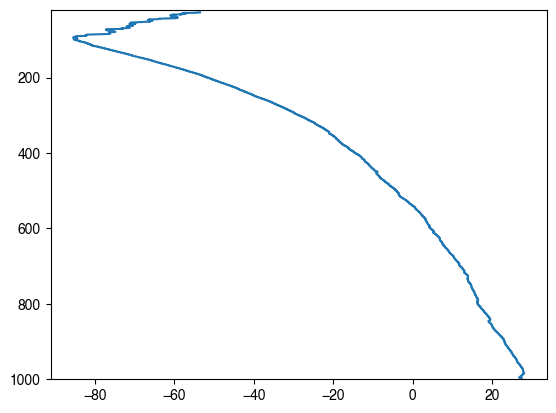

"portblair"

In [7]:
"extract column data by name"
function get_sounding_cols(df, station)
    if in(station, ["mangalore", "visakhapatnam", "portblair"])
        p = df[!,"P(hPa)"][:]
        T = df[!,"T(C)"][:]
        Td = df[!,"Dew(C)"][:]
        rh = df[!,"U(%)"][:]
        z = df[!,"Geo(gpm)"][:]
        wspd = df[!,"Wspd(m/s)"][:]
        wdir = df[!,"Wdir(d)"][:]
    else # slightly different keys
        p = df[!,"p(hPa)"][:]
        T = df[!,"T(dC)"][:]
        Td = df[!,"Dew(dC)"][:]
        rh = df[!,"U(%)"][:]
        z = df[!,"Geo(gpm)"][:]
        wspd = df[!,"Wspd(m/s)"][:]
        wdir = df[!,"Wdir(d)"][:]
    end
    u = wspd .* sind.(wdir)
    v = wspd .* cosd.(wdir)

    return p, T,Td, rh,z, wspd,wdir, u,v
end

p, T,Td, rh,z, wspd,wdir, u,v = get_sounding_cols(df, station)

# test plot
clf()
plot( T, p, label="Temperature (C)")
ylim(1000, 20)
station

In [8]:
# sounding variable functions

meanfinite(x, dims) = sum(x, dims=dims)./sum(isfinite, x, dims=dims)
anom(x; dims=ndims(x)) = x .- meanfinite(x, dims)

"Exner function T/θ = (p/p_0)^Rd/cp"
Exner(p) = (p/1000.0)^0.287 # = T/theta
th(T,p) = T/Exner(p)

th (generic function with 1 method)

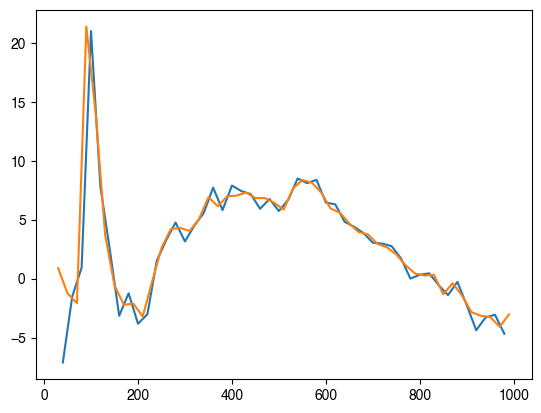

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd0fedc9d00>

In [9]:
# pressure levels to interploate to
plevs = 1020.0:-20.0:0.0

# test interpolation
upi = uniqueidx(p)
plot(plevs, itp(u[upi], p[upi])[plevs])
# test averaging
# plot(plevs, pavg(u, p plevs=plevs))


u_pl = pavg(u, p, plevs=plevs)
# plev is the level geometrically above and dynamically (pressure) below the binned observations
# probably suitable for pcolormesh
plot(plevs.+10, u_pl)

In [10]:
# inventory files, times
station="visakhapatnam"
    # read standard named files in the station's directory
    files = soundingfiles(station)
    # deduplicate sounding times
    fdt = imd_file_date.(files)
    fdt12 = round.(fdt, Dates.Hour(12))
    ui = uniqueidx(fdt12)
    fdt[ui] # exact datetimes with duplicates removed
    ord = sortperm(fdt[ui]) # guarantees ascending order
    cat(files[ui[ord]], fdt[ui[ord]], dims=2)


23×2 Matrix{Any}:
 "01MAY2023VSK.txt"                        2023-05-01T00:00:00
 "02MAY2023VSK.txt"                        2023-05-02T00:00:00
 "03MAY2023VSK.txt"                        2023-05-03T00:00:00
 "04MAY2023VSK.txt"                        2023-05-04T00:00:00
 "05MAY2023VSK.txt"                        2023-05-05T00:00:00
 "06MAY2023VSK.txt"                        2023-05-06T00:00:00
 "07MAY2023VSK.txt"                        2023-05-07T00:00:00
 "08MAY2023VSK.txt"                        2023-05-08T00:00:00
 "09MAY2023VSK.txt"                        2023-05-09T00:00:00
 "10MAY2023VSK.txt"                        2023-05-10T00:00:00
 "43150-20230511-00-Standard-Summary.txt"  2023-05-11T00:00:00
 "43150-20230512-00-Standard-Summary.txt"  2023-05-12T00:00:00
 "43150-20230513-00-Standard-Summary.txt"  2023-05-13T00:00:00
 "43150-20230514-00-Standard-Summary.txt"  2023-05-14T00:00:00
 "43150-20230515-00-Standard-Summary.txt"  2023-05-15T00:00:00
 "43150-20230516-00-Standard-Summary.

In [11]:
# start over and do a big loop to load and interpolate data to consistent levels

reldatapath = "../data/EKAMSAT_IMD/ekamsat"
plevs = 1020.0:-20.0:0.0

CamelStations = ["Chennai","Karaikal","Kochi","Kolkata","Mangalore","PortBlair","Visakhapatnam"]
stationnames = lowercase.(CamelStations)

# allocate gridded data arrays (pressure, location, launch time)
nt = 40 # allow for longest station mangalore?(37), extend & trim off extra later
T  = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
Td = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
rh = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
z  = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
u  = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
v  = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
time = zeros(DateTime, length(stationnames), nt)

sj = 0
for station in stationnames
    # read standard named files in the station's directory
    files = soundingfiles(station)
    sj += 1 # gridded station index
    # deduplicate sounding times
    fdt = imd_file_date.(files)
    fdt12 = round.(fdt, Dates.Hour(12))
    ui = uniqueidx(fdt12)
    fdt[ui] # exact datetimes with duplicates removed
    ord = sortperm(fdt[ui]) # guarantees ascending order
    #collect(zip( files[ui[ord]]], fdt[ui[ord]] ))
    
    tj = 0
    for ti in ui[ord]
        df = read_sonde( joinpath(reldatapath, station, files[ti]),
                 header=( station=="visakhapatnam" ? 7 : 3 )      )
        # extract ungridded hi-res data
        p_, T_,Td_, rh_,z_, wspd_,wdir_, u_,v_ = get_sounding_cols(df, station)
        # avg variables at the next time level
        tj += 1
        time[sj,tj] = fdt[ti]
        T[  :, sj, tj] .= pavg(T_ , p_, plevs=plevs)
        Td[ :, sj, tj] .= pavg(Td_, p_, plevs=plevs)
        rh[ :, sj, tj] .= pavg(rh_, p_, plevs=plevs)
        z[  :, sj, tj] .= pavg(z_ , p_, plevs=plevs)
        u[  :, sj, tj] .= pavg(u_ , p_, plevs=plevs)
        v[  :, sj, tj] .= pavg(v_ , p_, plevs=plevs)
    end
end

┌ Warning: thread = 1 warning: parsed expected 11 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/7lFhM/src/file.jl:577
┌ Warning: thread = 1 warning: parsed expected 11 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/7lFhM/src/file.jl:577
┌ Warning: thread = 1 warning: parsed expected 11 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/7lFhM/src/file.jl:577
┌ Warning: thread = 1 warning: parsed expected 11 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/7lFhM/src/file.jl:577
┌ Warning: thread = 1 warning: parsed expected 11 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columns

In [12]:
nt = sum(time.>DateTime(1000), dims=2)
collect(zip(CamelStations, nt))

7-element Vector{Tuple{String, Int64}}:
 ("Chennai", 26)
 ("Karaikal", 22)
 ("Kochi", 23)
 ("Kolkata", 23)
 ("Mangalore", 23)
 ("PortBlair", 26)
 ("Visakhapatnam", 23)

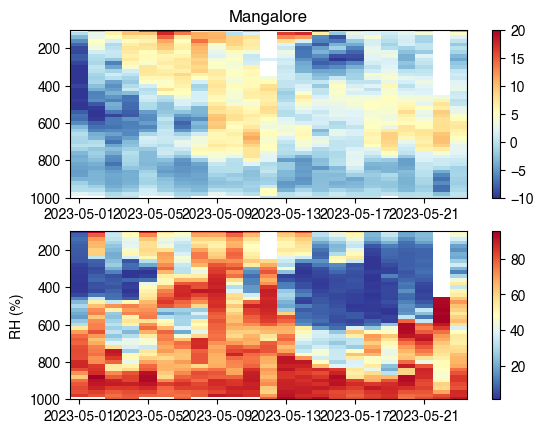

PyObject <matplotlib.colorbar.Colorbar object at 0x7fd0ffa95610>

In [13]:
# test time-pressure plot
sj = 5

clf()
subplot(2,1,1)
# pcolormesh( time[sj,:], plevs, anom(T[:,sj,:],dims=2) )
# pcolormesh( time[sj,:], plevs, anom(th.(T[:,sj,:],plevs),dims=2), vmin=-7, vmax=7, cmap=ColorMap("RdYlBu_r") )
pcolormesh( time[sj,1:nt[sj]], plevs, u[:,sj,1:nt[sj]], vmin=-10, vmax=20, cmap=ColorMap("RdYlBu_r") )
ylim(1000, 100)
colorbar()
title(CamelStations[sj])

subplot(2,1,2)
pcolormesh( time[sj,1:nt[sj]], plevs, rh[:,sj,1:nt[sj]], cmap=ColorMap("RdYlBu_r"))
ylim(1000, 100)
ylabel("RH (%)")
colorbar()

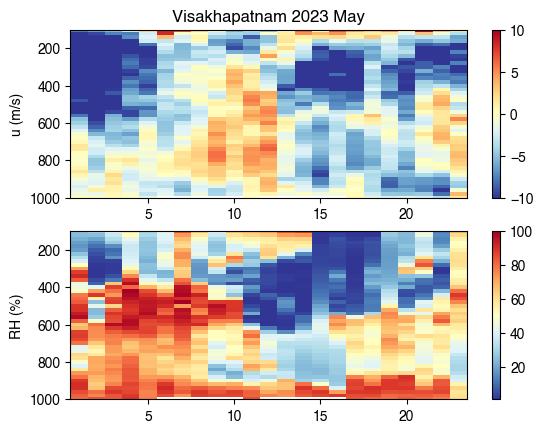

In [25]:
mpldate(timestamp, offset=DateTime(2023,4,30,0,0,0)) = Dates.value(timestamp-offset)/1000/60/60/24

for sj in 1:7
    clf()
    subplot(2,1,1)
    # pcolormesh( time[sj,:], plevs, anom(T[:,sj,:],dims=2) )
    # pcolormesh( time[sj,:], plevs, anom(th.(T[:,sj,:],plevs),dims=2), vmin=-7, vmax=7, cmap=ColorMap("RdYlBu_r") )
    pcolormesh( mpldate.(time[sj,1:nt[sj]]), plevs, u[:,sj,1:nt[sj]], vmin=-10, vmax=10, cmap=ColorMap("RdYlBu_r") )
    ylim(1000, 100)
    ylabel("u (m/s)")
    colorbar()
    title(CamelStations[sj]*" 2023 May")

    subplot(2,1,2)
    pcolormesh( mpldate.(time[sj,1:nt[sj]]), plevs, rh[:,sj,1:nt[sj]], cmap=ColorMap("RdYlBu_r"))
    ylim(1000, 100)
    ylabel("RH (%)")
    colorbar()
    
    savefig("../plot/$(CamelStations[sj])_u_rh.svg")
end